In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)



In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


#show_raw_visualization(df)


In [4]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 3


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [5]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [6]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)


In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [8]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)


In [9]:
#for x, y in dataset_val:
#    print(x, y)

In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(32)(inputs)
#outputs = keras.layers.Dense(1)(lstm_out)

print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 7), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [21]:
import keras_applications.resnet
import keras_applications.resnet_1d
import keras_applications.resnet_1d_common

import tensorflow.keras.utils as utils

base = keras_applications.resnet_1d.ResNet18(weights=None, include_top=False, input_tensor= inputs)

x = tf.keras.layers.Flatten()(base.output)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=base.inputs, outputs=x)

base50 = keras_applications.resnet_1d.ResNet50(weights=None, include_top=False, input_tensor= inputs)

x = tf.keras.layers.Flatten()(base50.output)
x = tf.keras.layers.Dense(1)(x)
model50 = tf.keras.Model(inputs=base50.inputs, outputs=x)


channels_last
x (None, 30, 64)
shortcut (None, 30, 64)
x1 (None, 30, 64)
x2 (None, 30, 64)
x1 (None, 30, 64)
x2 (None, 30, 64)
x (None, 30, 64)
shortcut (None, 15, 128)
x1 (None, 15, 128)
x2 (None, 15, 128)
x1 (None, 15, 128)
x2 (None, 15, 128)
x (None, 15, 128)
shortcut (None, 8, 256)
x1 (None, 8, 256)
x2 (None, 8, 256)
x1 (None, 8, 256)
x2 (None, 8, 256)
x (None, 8, 256)
shortcut (None, 4, 512)
x1 (None, 4, 512)
x2 (None, 4, 512)
x1 (None, 4, 512)
x2 (None, 4, 512)
channels_last
x (None, 30, 64)
shortcut (None, 30, 256)
x1 (None, 30, 64)
x2 (None, 30, 64)
x3 (None, 30, 256)
x1 (None, 30, 64)
x2 (None, 30, 64)
x3 (None, 30, 256)
x1 (None, 30, 64)
x2 (None, 30, 64)
x3 (None, 30, 256)
x (None, 30, 256)
shortcut (None, 15, 512)
x1 (None, 15, 128)
x2 (None, 15, 128)
x3 (None, 15, 512)
x1 (None, 15, 128)
x2 (None, 15, 128)
x3 (None, 15, 512)
x1 (None, 15, 128)
x2 (None, 15, 128)
x3 (None, 15, 512)
x1 (None, 15, 128)
x2 (None, 15, 128)
x3 (None, 15, 512)
x (None, 15, 512)
shortcut (None, 8,

In [12]:
from tensorflow.keras.utils import plot_model

In [13]:
base.summary()


Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 7)]     0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding1D)       (None, 120, 7)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv1D)             (None, 60, 64)       3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 64)       256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv4_block1_add (Add)          (None, 8, 256)       0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_out (Activation)   (None, 8, 256)       0           conv4_block1_add[0][0]           
__________________________________________________________________________________________________
zero_padding1d_5 (ZeroPadding1D (None, 10, 256)      0           conv4_block1_out[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv1D)    (None, 8, 256)       196864      zero_padding1d_5[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 8, 256)       1024        conv4_block2_1_conv[0][0]        
__________

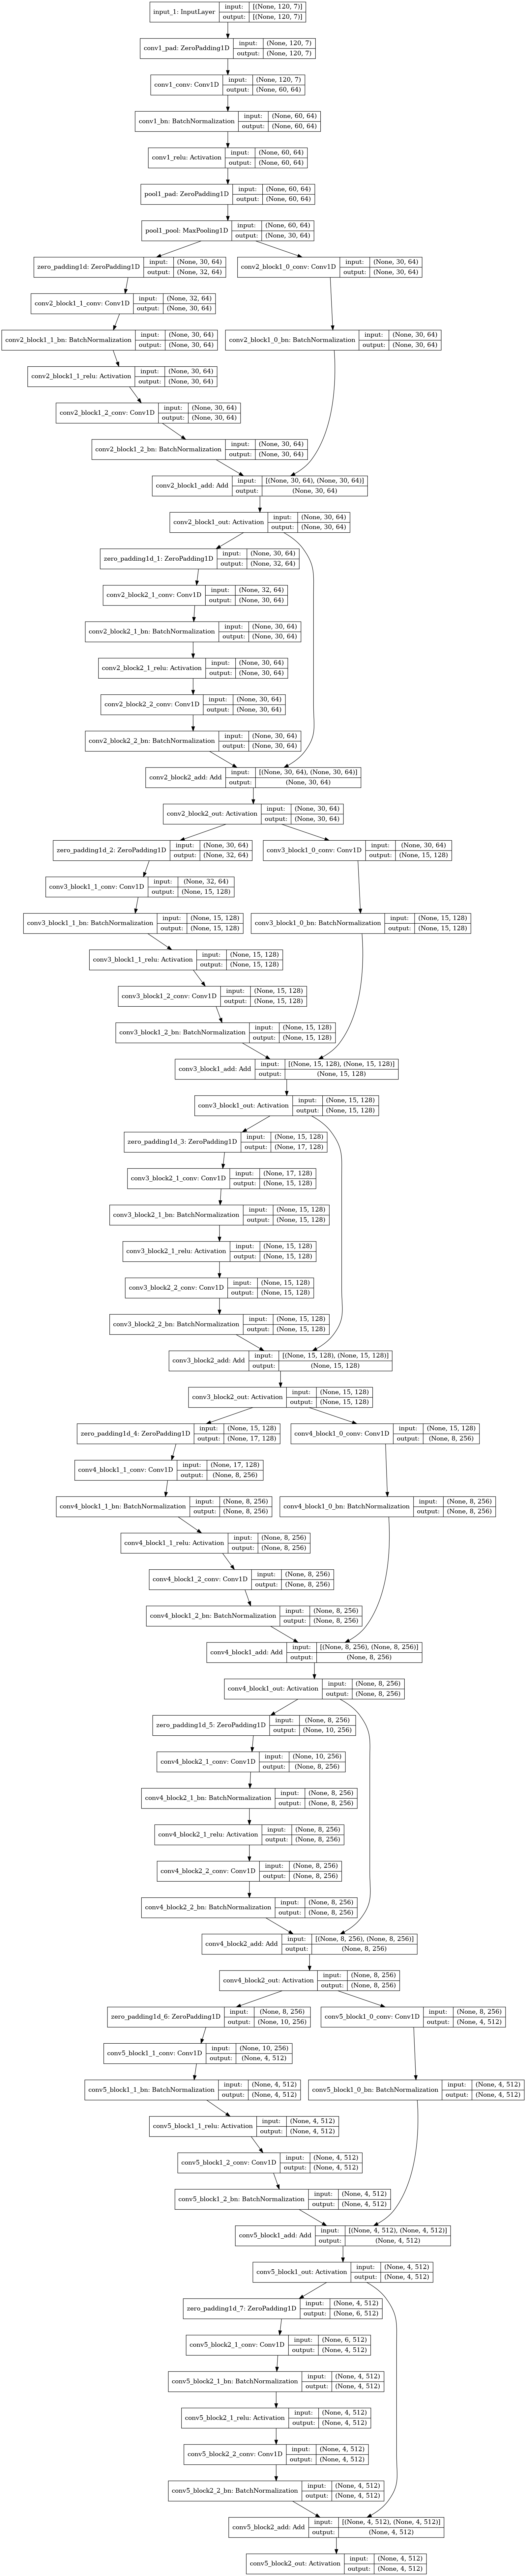

In [14]:
plot_model(base, show_shapes=True, show_layer_names=True)

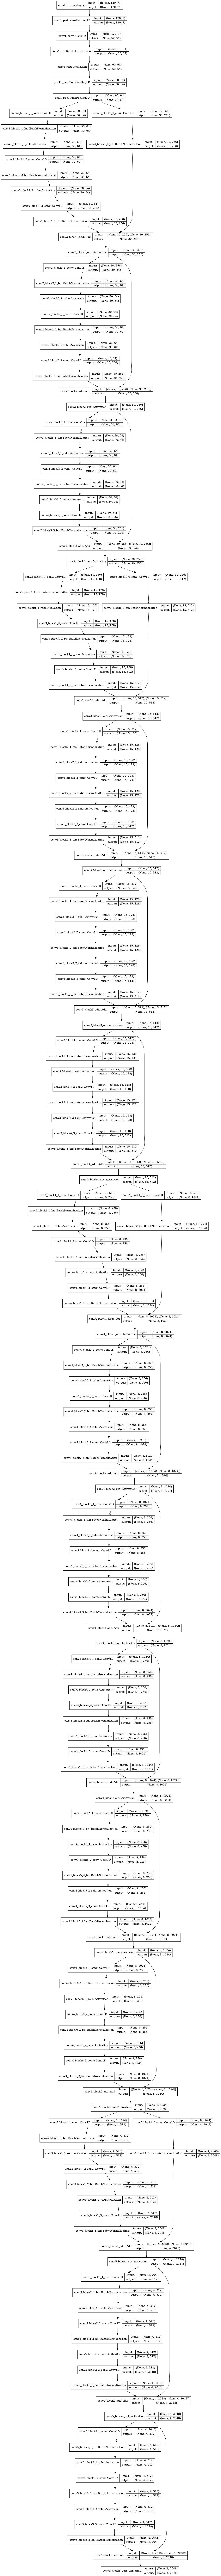

In [22]:
plot_model(base50, show_shapes=True, show_layer_names=True)

In [15]:

#import tensorflow.keras

#import keras_resnet.models

#shape, classes = (32, 3), 10

#x = tensorflow.keras.layers.Input(shape)

#print(x)

#model = keras_resnet.models.ResNet1D50(x, classes=classes)

#model.compile("adam", "categorical_crossentropy", ["accuracy"])

In [16]:

#model.compile("adam", "categorical_crossentropy", ["accuracy"])
model.compile(optimizer='adam',loss='mean_squared_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 7)]     0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding1D)       (None, 120, 7)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv1D)             (None, 60, 64)       3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 64)       256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

#print(dataset_train)
#print(dataset_val)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/3
1172/1172 [==============================] - 62s 48ms/step - loss: 1.4656 - val_loss: 39276.9727

Epoch 00001: val_loss improved from inf to 39276.97266, saving model to model_checkpoint.h5
Epoch 2/3
1172/1172 [==============================] - 55s 47ms/step - loss: 0.5240 - val_loss: 5571.8335

Epoch 00002: val_loss improved from 39276.97266 to 5571.83350, saving model to model_checkpoint.h5
Epoch 3/3
1172/1172 [==============================] - 59s 50ms/step - loss: 0.3458 - val_loss: 2006.7207

Epoch 00003: val_loss improved from 5571.83350 to 2006.72070, saving model to model_checkpoint.h5


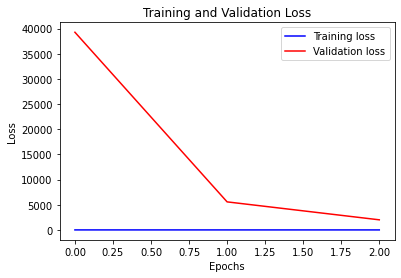

In [18]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


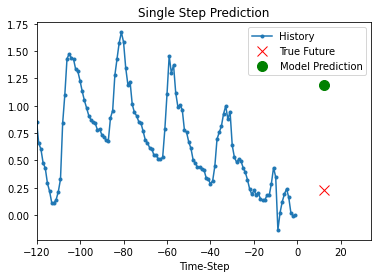

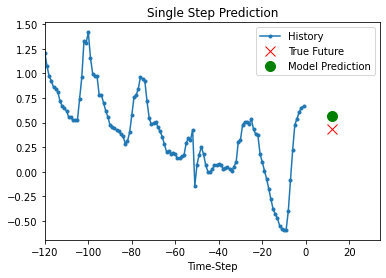

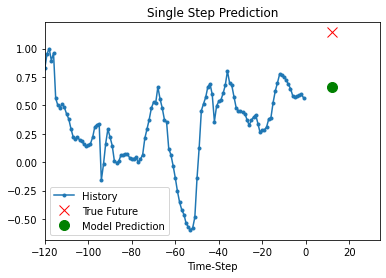

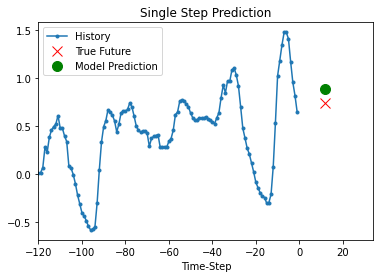

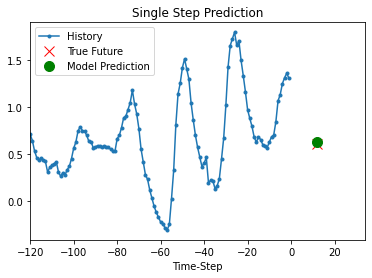

In [19]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


In [20]:

#training_y = tensorflow.keras.utils.to_categorical(training_y)

#model.fit(training_x, training_y)